In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# from IPython.display import Image
import mplhep as hep
hep.style.use('ATLAS')
import os
from tqdm import tqdm
import h5py

from concurrent.futures import ProcessPoolExecutor, as_completed
from scipy.integrate import simpson, trapezoid
from matplotlib.gridspec import GridSpec


In [2]:
import vtk

In [7]:
# 读取H5文件
def Covert_H5_Vtk(cent=[0,20],event=0):
    m=cent[0]
    n=cent[1]
    h5_file_path = f'/media/mengzhu/MZ/d_Au_work/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_{m}_{n}/entropy3D_y0_4p0_sigma_2p5_L_factor_2p0_R_factor_2p0_P_factor_5p4_alpha_1p0_beta_0p333.h5'  # 替换为你的H5文件路径
    dataset_name = f'event_{event}'  # 替换为你的数据集名称

    # 打开H5文件并读取数据
    with h5py.File(h5_file_path, 'r') as h5_file:
        data = h5_file[dataset_name][:]

    # 创建VTK数据结构
    vtk_data = vtk.vtkStructuredPoints()
    vtk_data.SetDimensions(200, 200, 121)  # 注意维度顺序，VTK中是 (x, y, z)
    vtk_data.SetSpacing(0.16, 0.16, 0.115)  # 设置数据点之间的间距，根据实际情况调整
    vtk_data.SetOrigin(0.0, 0.0, 0.0)  # 设置数据的起始点，根据实际情况调整

    # 分配内存并设置数据类型
    vtk_data.AllocateScalars(vtk.VTK_FLOAT, 1)

    # 将数据填充到VTK数据结构中
    for z in range(121):
        for y in range(200):
            for x in range(200):
                vtk_data.SetScalarComponentFromFloat(x, y, z, 0, data[z, y, x])

    # 写入VTK文件
    vtk_file_path = f'./data/entropy3d_{m}_{n}_event_{event}.vtk'  # 输出的VTK文件路径
    writer = vtk.vtkStructuredPointsWriter()
    writer.SetFileName(vtk_file_path)
    writer.SetInputData(vtk_data)
    writer.Write()

    print(f"VTK文件已成功写入：{vtk_file_path}")

In [8]:
Covert_H5_Vtk(cent=[80,100],event=0)

VTK文件已成功写入：./data/entropy3d_80_100_event_0.vtk


# entropy3d 可视化

100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.80it/s]


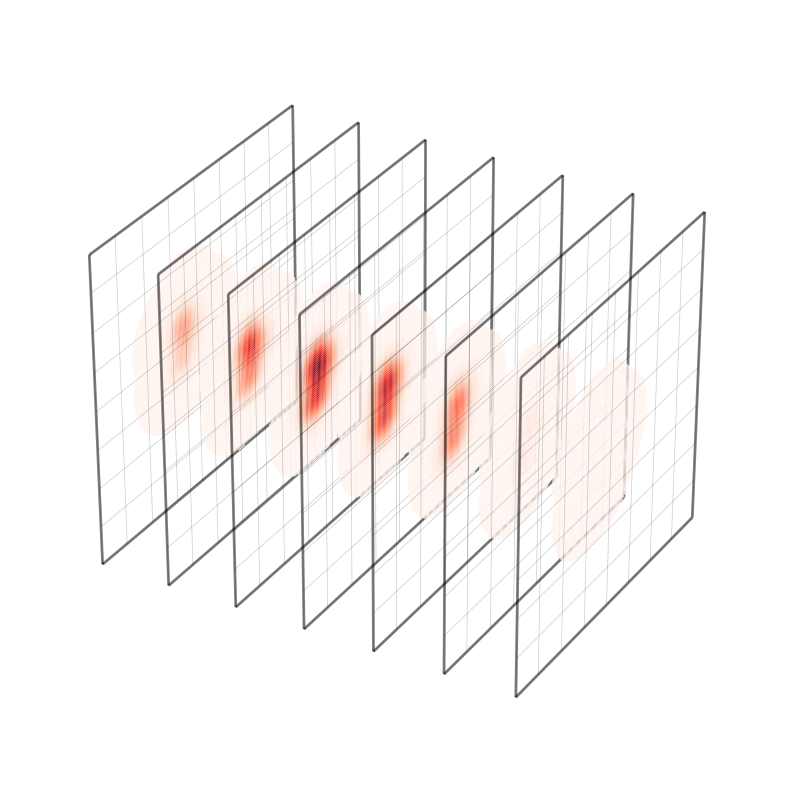

In [5]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors

# 打开 HDF5 文件
entropy3d_path = '/media/mengzhu/MZ/d_Au_work/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20/entropy3D_y0_4p0_sigma_2p5_L_factor_2p0_R_factor_2p0_P_factor_5p4_alpha_1p0_beta_0p333.h5'


with h5py.File(entropy3d_path, 'r') as f:
    data = f['event_0'][:]  # 替换 'dataset_name' 为实际数据集名称

# 数据形状 (Z, X, Y)
Z, X, Y = data.shape
# 计算整个数据集的最大值和最小值，用于归一化
data_max = np.nanmax(data)
data_min = np.nanmin(data)

# 创建三维绘图
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')

# 遍历每个切片并绘制
for z in tqdm(range(0, Z, 20)):  # 按步长 17 遍历 Z 轴切片
    # 提取 z 切片
    slice_data = data[z, 20:-20, 20:-20]
    # 将0值替换为NaN，以实现透明效果
    slice_data[slice_data == 0.0] = np.nan

    # 创建 x, y 网格
    x, y = np.meshgrid(np.arange(160), np.arange(160))

    # 绘制热力图的透明表面
    ax.plot_surface(
        -np.full_like(x, z), x, y,
        facecolors=plt.cm.Reds((slice_data - data_min) / (data_max - data_min)), rstride=1, cstride=1, shade=False,
        edgecolor='none'  # 确保边缘不绘制颜色
    )
    # 绘制内部网格线，使用较小的步长
    ax.plot_wireframe(
        -np.full_like(x, z), x, y,
        color='black', linewidth=0.5, alpha=0.2, rstride=20, cstride=20
    )

    # 绘制外围网格线，使用较大的步长
    ax.plot_wireframe(
        -np.full_like(x, z), x, y,
        color='black', linewidth=2, alpha=0.5, rstride=200, cstride=200
    )


# # 移除坐标轴和框架
ax.set_axis_off()

# 设置视角
ax.view_init(elev=30, azim=120)

# 设置背景为透明
# fig.patch.set_alpha(0.0)
# ax.patch.set_alpha(0.0)
# 调整坐标轴的显示范围，减少空白区域
# ax.set_xlim([X*0.1, X*0.9])
# ax.set_ylim([Y*0.1, Y*0.9])
# ax.set_zlim([0, Z])
# # 自动确定坐标轴的显示范围
# ax.autoscale()

# plt.tight_layout()
# 保存图像为PDF
# plt.savefig('./d_Au_work/fig/entropy_3d_slice_part.pdf', bbox_inches='tight', pad_inches=0.0)
plt.show()